In [45]:
import torch
from train import get_data
from models import MovementPredictor
from util.data import ROIS
import numpy as np
import pandas as pd

In [16]:
device = torch.device('cuda')
model = MovementPredictor(
    num_regions=len(ROIS),
    hidden_dim=512,
    num_convs=1,
    attn_hidden_dim=256,
    t_in=120,
).to(device)

In [17]:
model

MovementPredictor(
  (region_embed): Embedding(4, 512)
  (initial_conv): Conv1d(1, 512, kernel_size=(25,), stride=(1,), padding=(12,))
  (convs): Sequential(
    (0): Conv1d(512, 512, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): ReLU()
  )
  (pre_attn_proj): Linear(in_features=61440, out_features=512, bias=True)
  (attn): RegionAttention(
    (val_proj): Linear(in_features=512, out_features=256, bias=True)
    (key_proj): Linear(in_features=512, out_features=256, bias=True)
    (query_proj): Linear(in_features=512, out_features=256, bias=True)
    (out_proj): Linear(in_features=256, out_features=512, bias=True)
  )
  (mlp): MLP(
    (initial_proj): Linear(in_features=512, out_features=512, bias=True)
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=512, out_features=512, bia

In [18]:
state_dict = torch.load('model.pt')

In [19]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [93]:
model(x_torch)

(tensor([[0.1302]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[[[0., 1., 0., 0.],
           [1., 0., 0., 0.],
           [1., 0., 0., 0.],
           [0., 0., 0., 1.]]]], device='cuda:0', grad_fn=<SoftmaxBackward0>))

In [81]:
tr_dataset, _ = get_data()
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=256)

Loading cached data from /scratch/users/akashc/misc_proj/cs339n/final/connectx-decoding/data/raw_data_t0.05.pkl
Recording ee8b36de-779f-4dea-901f-e0141c95722b: 551 trials, T=120
(551, 120) (551,)
(551, 120) (551,)
(551, 120) (551,)
(551, 120) (551,)
eid='ee8b36de-779f-4dea-901f-e0141c95722b' all_inputs[-1].shape=(551, 4, 120)
Recording 81a78eac-9d36-4f90-a73a-7eb3ad7f770b: 1103 trials, T=120
(1103, 120) (1103,)
(1103, 120) (1103,)
(1103, 120) (1103,)
(1103, 120) (1103,)
eid='81a78eac-9d36-4f90-a73a-7eb3ad7f770b' all_inputs[-1].shape=(1103, 4, 120)
Recording 88d24c31-52e4-49cc-9f32-6adbeb9eba87: 545 trials, T=120
(545, 120) (545,)
(545, 120) (545,)
(545, 120) (545,)
(545, 120) (545,)
eid='88d24c31-52e4-49cc-9f32-6adbeb9eba87' all_inputs[-1].shape=(545, 4, 120)
(2199, 4, 120) (2199, 4)
Num blank trials:  0


In [82]:
results = []
for x, _ in tr_loader:
    x = x.to(device).float()
    _, attn_weights = model(x)
    results.append(attn_weights)
    
all_attn_weights = torch.cat(results)

In [83]:
all_attn_weights.shape

torch.Size([1979, 1, 4, 4])

In [87]:
sum_attn_weights = all_attn_weights.squeeze().sum(0)
# norm_train_attn_weights = 

In [89]:
norm_tr_attn_weights = sum_attn_weights / sum_attn_weights.sum(1, keepdim=True)

In [90]:
norm_tr_attn_weights

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]], device='cuda:0', grad_fn=<DivBackward0>)

In [66]:
region_map = {
    0: ['ACB', 'FS'],
    1: 'CP',
    2: 'MOp',
    3: 'MOs',
}

def get_connectome_mat(file='proj_strengths.xlsx'):
    projectome = pd.read_excel(file, sheet_name='W_ipsi', index_col=0)
    mat = np.zeros((len(ROIS), len(ROIS)))
    for i, r_src in region_map.items():
        for j, r_tgt in region_map.items():
            res = projectome.loc[r_src, r_tgt].sum()
            if isinstance(res, pd.Series):
                res = res.sum()

            mat[i, j] = res
    
    mat /= mat.sum(1, keepdims=True)
    
    return mat

/home/groups/willhies/anaconda3/envs/sutr/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Text(0.5, 1.0, 'Connectome-derived projection strengths')

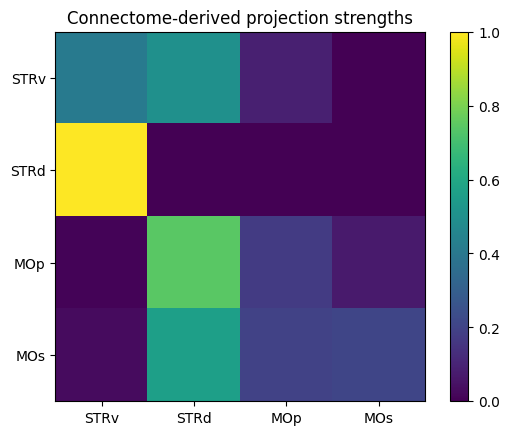

In [77]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure()
ax = plt.gca()
ax.set_xticks(np.arange(len(ROIS)), labels=ROIS)
ax.set_yticks(np.arange(len(ROIS)), labels=ROIS)

plt.imshow(get_connectome_mat())
plt.colorbar()
plt.title('Connectome-derived projection strengths')

Text(0.5, 1.0, 'Learned inter-region projection strengths')

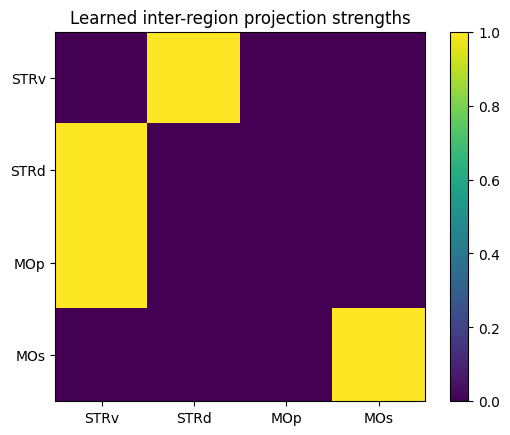

In [92]:
norm_tr_attn_weights = norm_tr_attn_weights.detach().cpu().numpy()

plt.figure()
ax = plt.gca()
ax.set_xticks(np.arange(len(ROIS)), labels=ROIS)
ax.set_yticks(np.arange(len(ROIS)), labels=ROIS)

plt.imshow(norm_tr_attn_weights)
plt.colorbar()
plt.title('Learned inter-region projection strengths')